## Семинар 2 "Распознавание рукописных цифр"

ФИО: Сапаев Дилшод Рахимович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import torch
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
import time
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

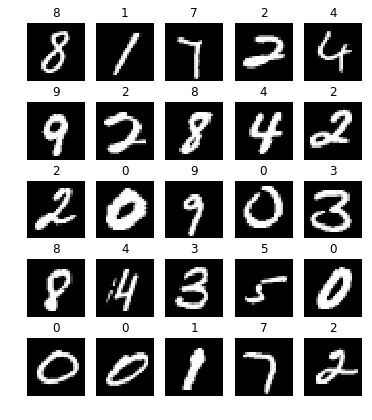

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None, data_loader=train_loader):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in data_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output()
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.314/0.309	Accuracy: 0.918/0.919

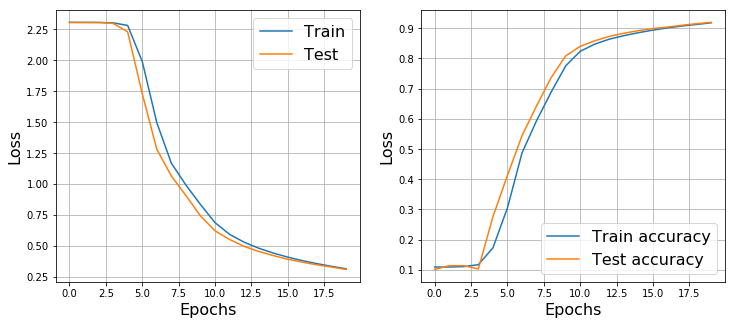

CPU times: user 7min 33s, sys: 7.11 s, total: 7min 41s
Wall time: 3min 57s


In [7]:
%%time
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [10]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.037/0.087	Accuracy: 0.990/0.975

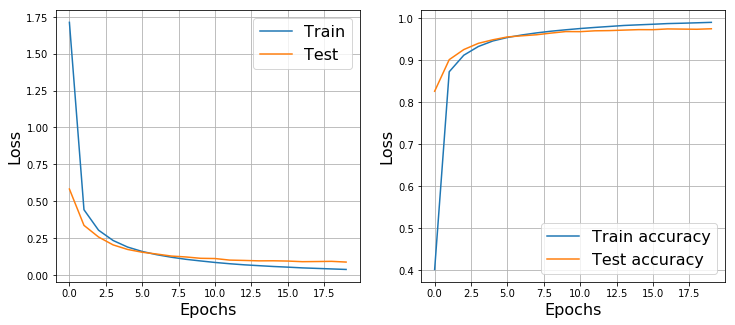

CPU times: user 7min 14s, sys: 6.4 s, total: 7min 20s
Wall time: 3min 44s


In [11]:
%%time
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01)

In [12]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.045/0.082	Accuracy: 0.987/0.974

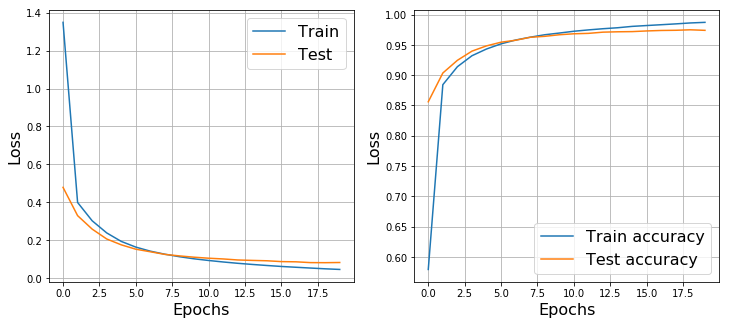

CPU times: user 7min 27s, sys: 6.31 s, total: 7min 33s
Wall time: 3min 49s


In [13]:
%%time
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01)

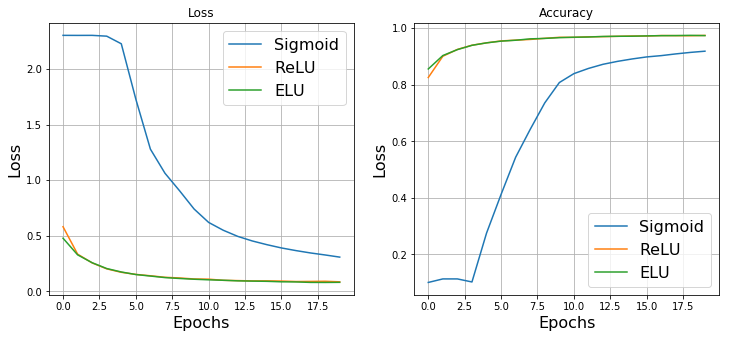

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [31]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
#         dydX = 1. + np.square(self.tanh)
        return dLdy / np.square(np.cosh(self.X))

    def step(self, learning_rate):
        pass

In [32]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.031/0.078	Accuracy: 0.993/0.975

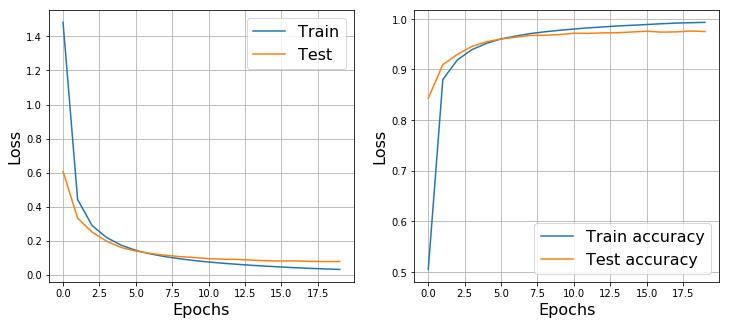

CPU times: user 7min 33s, sys: 6.79 s, total: 7min 40s
Wall time: 3min 56s


In [33]:
%%time
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01)

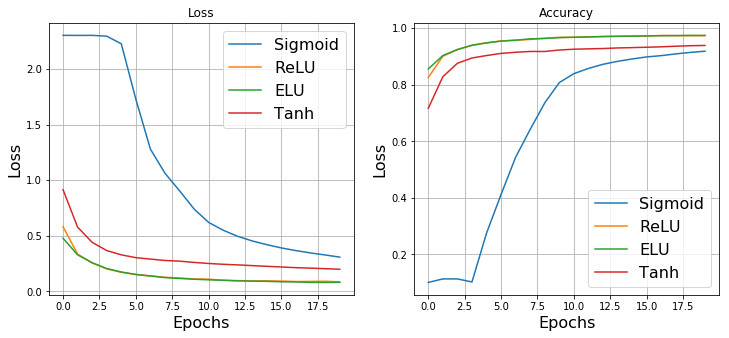

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

### Часть 3: Анализ ошибок

In [19]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

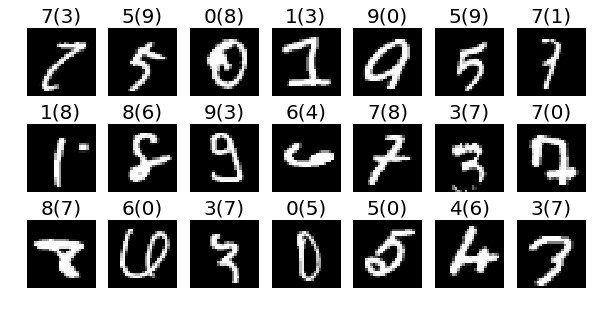

In [20]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [21]:
import PIL
from skimage.transform import rotate
from skimage.util import random_noise
from torchvision.transforms import RandomAffine
from torch.utils.data import ConcatDataset

In [22]:
sample_x = train_dataset[0][0].numpy()
sample_y = train_dataset[0][1].numpy()

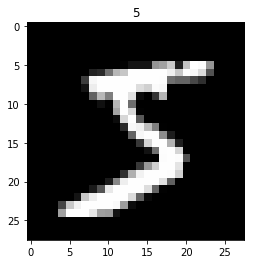

In [23]:
plt.title(sample_y)
plt.imshow(sample_x.reshape(28, 28), cmap=plt.cm.Greys_r)

In [24]:
rand_rotate = RandomAffine(15)
rand_translate = RandomAffine(0, translate=(0.1, 0.1))
rim = PIL.Image.fromarray(255 / (np.max(sample_x)-np.min(sample_x)) * (sample_x.reshape(28, 28)-np.min(sample_x)))

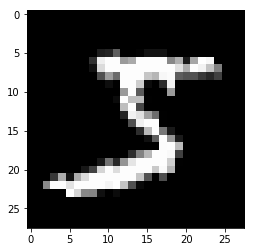

In [75]:
plt.imshow(rand_rotate(rim))

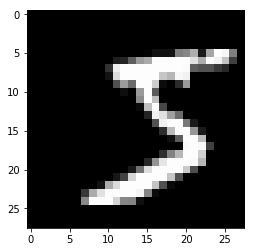

In [76]:
plt.imshow(rand_translate(rim))

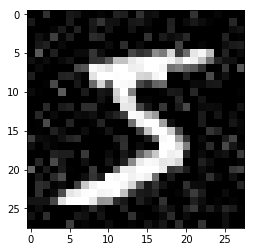

In [189]:
rand_noised = random_noise(np.asarray(rim) / np.max(rim), var = 0.01)
plt.imshow(rand_noised, cmap=plt.cm.Greys_r)

In [78]:
# остальость тольк загрузить это в Dataloader и запустить обучение

In [284]:
transform_rot = transforms.Compose([
                       transforms.RandomAffine(15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [285]:
transform_move = transforms.Compose([
                       transforms.RandomAffine(0, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [302]:
def lmbd(img):
    return PIL.Image.fromarray(random_noise(np.asarray(img), var = 0.01))

transform_noise = transforms.Compose([
                       transforms.Lambda(lmbd),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                    ])

In [303]:
# transform_all = transforms.Compose([
#                        transforms.RandomAffine(15, (0.1, 0.1)),
#                        transforms.Lambda(lmbd),
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                     ])

In [304]:
train_rot_dataset = MNIST('.', train=True, download=True, transform=transform_rot)
train_mov_dataset = MNIST('.', train=True, download=True, transform=transform_move)
train_noz_dataset = MNIST('.', train=True, download=True, transform=transform_noise)

In [306]:
big_dataset = ConcatDataset([train_dataset, train_rot_dataset, train_mov_dataset, train_noz_dataset])
# big_dataset = ConcatDataset([train_dataset, transform_all]) # 2 часа ночи, я не хочу разбираться что не так :с
rot_dataset = ConcatDataset([train_dataset, train_rot_dataset])
mov_dataset = ConcatDataset([train_dataset, train_mov_dataset])
noz_dataset = ConcatDataset([train_dataset, train_noz_dataset])

In [307]:
train_loader_big = DataLoader(big_dataset, batch_size=32, shuffle=True)
train_loader_rot = DataLoader(rot_dataset, batch_size=32, shuffle=True)
train_loader_mov = DataLoader(mov_dataset, batch_size=32, shuffle=True)
train_loader_noz = DataLoader(noz_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.160/0.148	Accuracy: 0.956/0.959

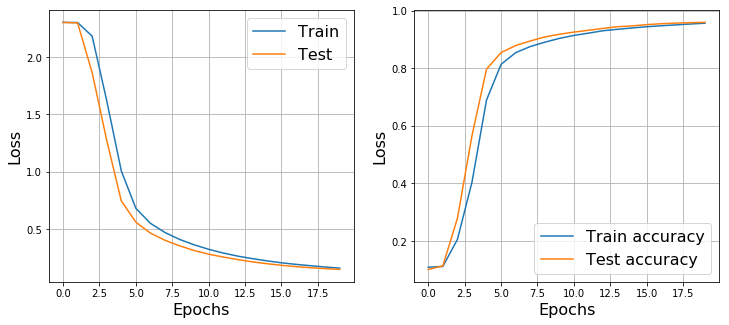

CPU times: user 16min 17s, sys: 15.8 s, total: 16min 33s
Wall time: 8min 31s


In [290]:
%%time
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_r, ts_s_r, tr_ac_s_r, ts_ac_s_r = train(network, 20, 0.01, data_loader=train_loader_rot)

Epoch 19... (Train/Test) NLL: 0.224/0.140	Accuracy: 0.938/0.963

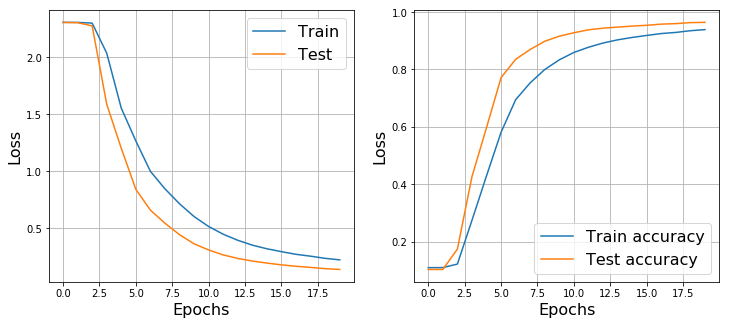

CPU times: user 17min 31s, sys: 16.6 s, total: 17min 47s
Wall time: 9min 7s


In [291]:
%%time
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_m, ts_s_m, tr_ac_s_m, ts_ac_s_m = train(network, 20, 0.01, data_loader=train_loader_mov)

Epoch 19... (Train/Test) NLL: 0.140/0.151	Accuracy: 0.962/0.956

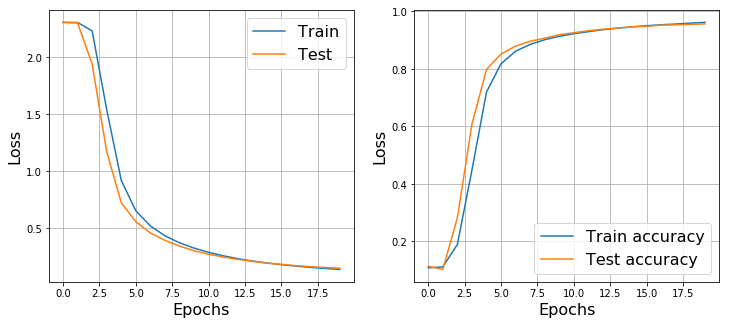

CPU times: user 22min 33s, sys: 22 s, total: 22min 55s
Wall time: 11min 49s


In [292]:
%%time
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_n, ts_s_n, tr_ac_s_n, ts_ac_s_n = train(network, 20, 0.01, data_loader=train_loader_noz)

Epoch 19... (Train/Test) NLL: 0.109/0.073	Accuracy: 0.969/0.979

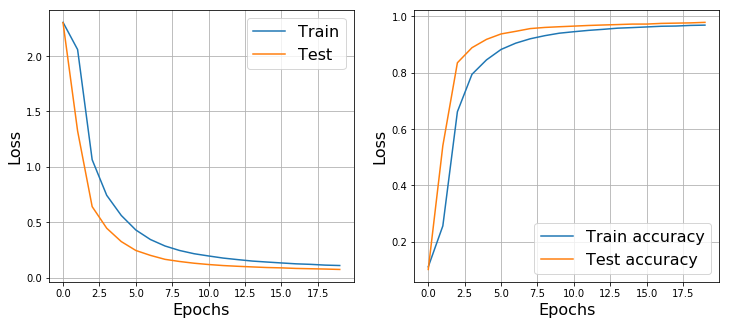

CPU times: user 41min 57s, sys: 41.1 s, total: 42min 38s
Wall time: 21min 52s


In [308]:
%%time
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_all, ts_s_all, tr_ac_s_all, ts_ac_s_all = train(network, 20, 0.01, data_loader=train_loader_big)

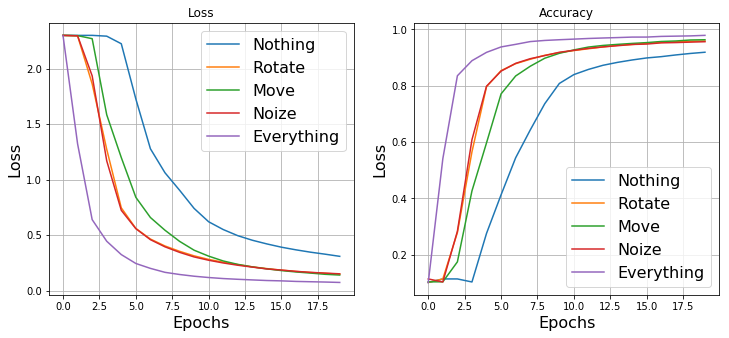

In [309]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Nothing')
plt.plot(ts_s_r, label='Rotate')
plt.plot(ts_s_m, label='Move')
plt.plot(ts_s_n, label='Noize')
plt.plot(ts_s_all, label='Everything')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Nothing')
plt.plot(ts_ac_s_r, label='Rotate')
plt.plot(ts_ac_s_m, label='Move')
plt.plot(ts_ac_s_n, label='Noize')
plt.plot(ts_ac_s_all, label='Everything')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

***Как и предполагалось, Агументация улучшает как точность, так и скорость обучения (в количестве эпох), но скорость вычисления одной эпохи падает. Это очень легко объясняется тем, что на каждой эпохе данных в 2(4) раза больше. Если использовать все 3 вида Агументации, то это все очень долго вычисляется, но точнсть в итоге лучше. В целом понятно зачем это все нужно и где это применить, хотя конкретно на данном датасете лучше оказалось просто взять ReLU (а еще лучше ReLU + Агументация, это я не проверял, но звучит логично)  
Возможно корректнее сравнивать 20 эпоху в оригинальном датасете и 10(5) в датасете с агументацие, в таком случае разницы почти нет***